# Определение возраста покупателей

Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека.
В вашем распоряжении набор фотографий людей с указанием возраста.

В ходе проекта необходимо решить задачу регрессии (предсказание возраста по фотографии)

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.optimizers import Adam


plt.rcParams["figure.figsize"] = (10,10)

**Посмотрим на размер выборки**

Скачаем csv файл, в котором для каждой картинки указана правильный возраст человека на фотографии

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Размер выборки составляет 7591 фотография. Пропусков в возрасте нет

In [ ]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Видим, что средний возраст 31 год, минимальный 1 год (здесь интересно было бы посмотреть на эту фотографию), максимальный возраст - 100 лет

**Построим график распределения возраста в выборке**

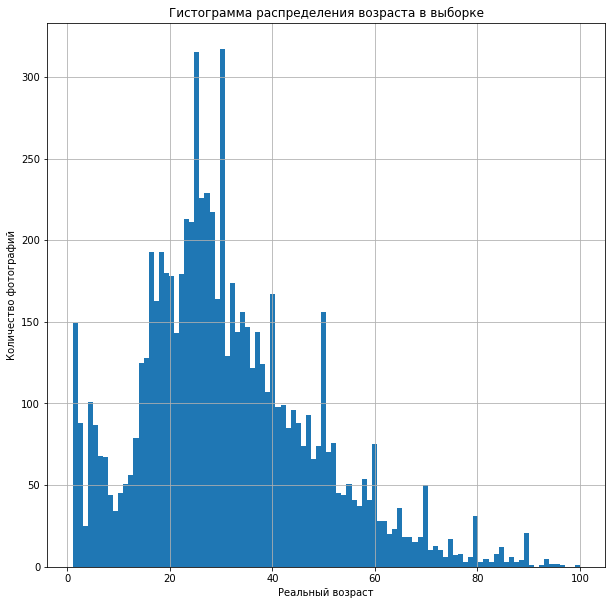

In [ ]:
plt.grid()

# bins=100, так как возраст от 1 до 100 и это дискретная величина
# поэтому можем разбить на 100 корзин
plt.hist(labels['real_age'], bins=100);

plt.title('Гистограмма распределения возраста в выборке')
plt.xlabel('Реальный возраст')
plt.ylabel('Количество фотографий');

Выводы:

- Данные распределены практически нормально вокруг среднего (31 год)
- По гистограмме видим, что есть аномально много фотографий с возрастом 1 год - скорее всего это выбросы. Ведь по задаче - мы должны по фотографии понять возраст покупателей, а младенцы не могут быть покупателями. Хотя, с точки зрения бизнеса - может иметь смысл определять возраст детей, так как они приходят с родителями и магазин может предложить им детские товары (смеси, подгузники и т.д). А у нас как раз одна из задач - "предлагать товары, которые могут заинтересовать покупателей этой возрастной группы", поэтому родителям с детьми можно дополнительнопредлагать детские товары
- есть узкие пики при значениях 20, 25, 30, 35, 40, 50, 60, 70, 80, 90 - возможно связано с округлением возраста (кто-то размечал фотографии приблизительно и округлял возраст)

**Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.**

Выполним загрузку с помощью динамической загрузки данных - генератора ImageDataGenerator

In [ ]:
# выполним нормализацию данных (rescale)
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


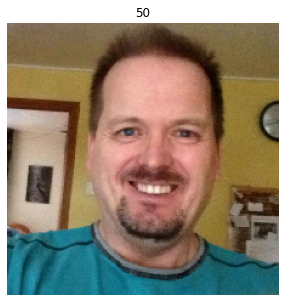

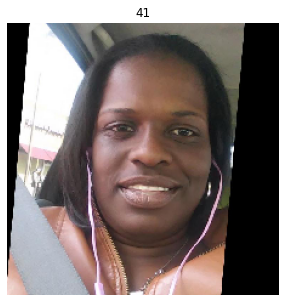

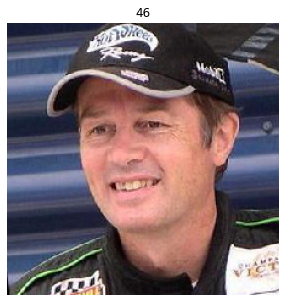

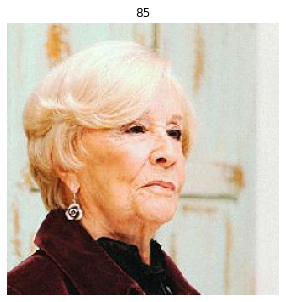

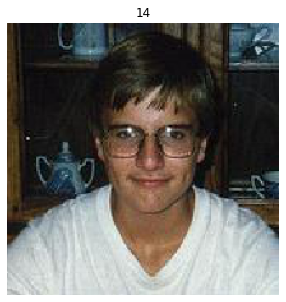

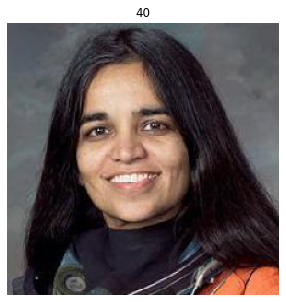

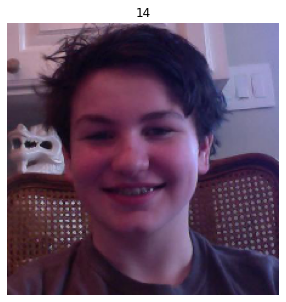

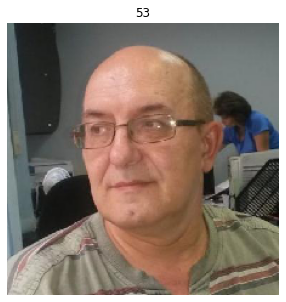

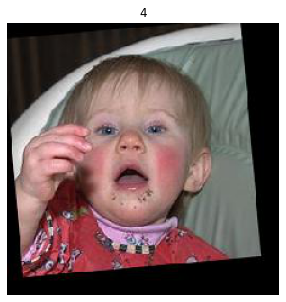

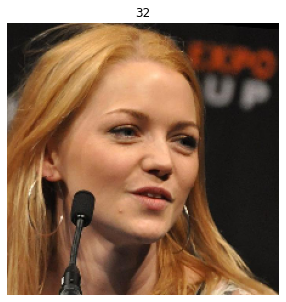

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)

for i in range(10):
    # [0] - первый батч
    # [0] - пиксели картинок (масштабированные) - признаки / [1] - это таргет - возраст
    # [i] - номер элемента - первая картинка и тд
    plt.imshow(train_gen_flow[0][0][i])
    plt.title(train_gen_flow[0][1][i])
    plt.axis('off')
    plt.show()

Вывод 25 первых картинок как плитка

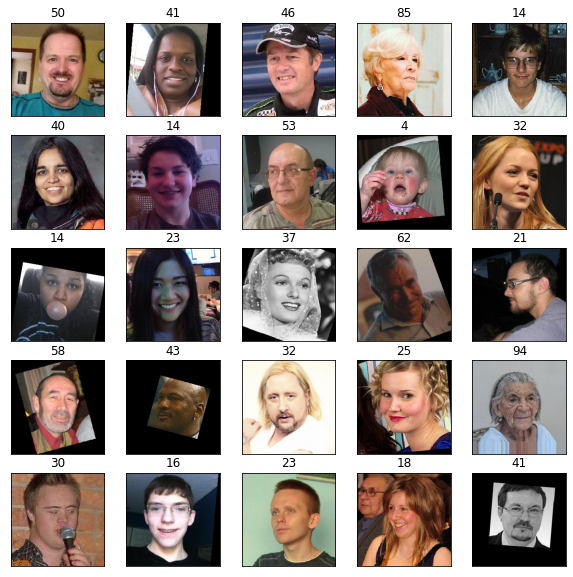

In [ ]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_gen_flow[0][0][i], cmap=plt.cm.binary)
    plt.title(train_gen_flow[0][1][i])

Промежуточный вывод:
 - по первым 25 картинкам видно, что в датасете общая ориентация фотографий вертикальная, но присутствуют фотографии, которые повернутые (значит аугментация, связанная с поворотом не требуется), есть цветные и черно-белые фотографии (значит не требуется аугментация по цвету) и есть фотографии уменьшенные фотографии (вокруг был добавлен черный фон, чтобы на вход модели подавать изображения одинакового размера)

 - исходя из предудыщего пункта - при аугментации добавим только зеркальные фотографии, чтобы модель работала и с такими данными

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
                validation_split=0.25,
                rescale=1/255.,
                horizontal_flip=True,
                vertical_flip=False,
                rotation_range=0,
                width_shift_range=0,
                height_shift_range=0)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')

    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    # test == validation
    test_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    #ResNET - base model

    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001) # base 0.001 learning rate

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_gen_flow, test_gen_flow, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_gen_flow,
          validation_data=test_gen_flow,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2)
    
    return model


```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-09-01 10:16:03.369624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-01 10:16:03.686055: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 239.1736 - mae: 11.0270 - val_loss: 894.5708 - val_mae: 25.0639
Epoch 2/10
178/178 - 37s - loss: 58.8004 - mae: 5.8282 - val_loss: 646.5445 - val_mae: 20.0711
Epoch 3/10
178/178 - 37s - loss: 30.3405 - mae: 4.2053 - val_loss: 266.5337 - val_mae: 11.9669
Epoch 4/10
178/178 - 37s - loss: 19.5811 - mae: 3.3907 - val_loss: 114.0320 - val_mae: 8.1944
Epoch 5/10
178/178 - 37s - loss: 13.3559 - mae: 2.8509 - val_loss: 83.3990 - val_mae: 7.0395
Epoch 6/10
178/178 - 37s - loss: 10.2954 - mae: 2.4672 - val_loss: 68.4121 - val_mae: 6.3336
Epoch 7/10
178/178 - 37s - loss: 8.2736 - mae: 2.1526 - val_loss: 67.6353 - val_mae: 6.2412
Epoch 8/10
178/178 - 37s - loss: 7.6335 - mae: 2.0844 - val_loss: 87.9400 - val_mae: 7.4445
Epoch 9/10
178/178 - 37s - loss: 8.2578 - mae: 2.1871 - val_loss: 67.0113 - val_mae: 6.1785
Epoch 10/10
178/178 - 38s - loss: 7.9771 - mae: 2.1296 - val_loss: 67.4780 - val_mae: 6.3231
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 67.4780 - mae: 6.3231
Test MAE: 6.3231

```

## Анализ обученной модели

Напишите выводы здесь

В качестве основы была взята модель ResNET50 с начальными весами, полученными при обучении на датасете ImageNET.
Последний слой был изменен - добавлен 1 нейрон вместо 1000 в базе и использована фукнция активации ReLU (чтобы ответ был неотрицательным)

Скорость обучение в оптимизаторе Adam была задана 0.0001 и при НС обучалась на 10 эпохах

Как итог, метрика МАЕ = 6.32, что меньше требуемых в задании 8

Это значит, что средняя ошибка нашей НС при определении возраста +- 6 лет

Помним, что перед нами от бизнеса были поставлены 2 задачи:
- рекоммендовать доп товары для покупателей  разных возрастных групп
- контролировать добросовестноть кассиров при продаже алкоголя

Такая точность нашей итоговой модели (+- 6 лет) подходит для первой задачи - определение возрастной группы, к которой принадлежит клиент, чтобы можно было сделать рекоммендацию доп товаров. Однако, для второй задачи (контроль кассиров при продаже алкоголя) - точность получилась низкая, поэтому здесь нудна другая система контроля, отличная от определения возраста по фотографии (например, чтобы при продаже алкоголя всегда показывался паспорт и этот факт регистрировался в системе контроля)

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера v.2 <a class="tocSkip"> </h2>    
    
     
  
Теперь почти идеально, молодец! Принимаю твой проект)
    
Могу поделиться такими ссылками для углубленного изучения темы спринта:
    
- Видеокурс от Stanford University: https://www.youtube.com/watch?v=vT1JzLTH4G4&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk
    
- Курс от Физтех-школы Прикладной Математики и Информатики МФТИ: https://vk.com/dlschool_mipt
    
- Курс Нейронные сети и компьютерное зрение от Sumsung: https://stepik.org/course/50352/promo#toc    
    
    
В этом проекте все шаги отработаны. С интересом читал твои размышления, код и выводы. Что ещё для дальнейшего улучшения качества возможно сделать?
    
Опишу здесь некоторые идеи:
    
1. Качество данных на входе: оценить еще раз возраст по фото.
2. Анализ ошибок: к примеру модель сильно ошибается на сегменте пожилых людей, зато почти идеально работает с детьми. Тогда мы поймем, каких возрастов фото было бы хорошо добавить в выборку для дообучения.
3. Дополнительно изучить распределение целевого признака, возможно что выборка была составлена неслучайным образом (видна небольшая бимодальность), посмотреть, каких возрастных групп представлено мало, чтобы их потом добавить в выборку.
    
Но цель нашего проекта достигнута. Рад был тебе помочь)
    
Удачи тебе в финальном проекте!
  
</div>

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы